**This Exercise shows how to use Google colab to apply regression models.**
**Copy the Colab notebook and data to your google drive before proceeding.**

Step 1: Connect Google drive that stores the data with your Google Colab Notebook

In [1]:
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# make matplotlib figures appear inline in the notebook 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [3]:
downloaded = drive.CreateFile({'id':'1Sx2bzyJu6VljsDrB0k-qu-7WUN2Wzm4n'}) # replace the id with id of file you want to access
downloaded.GetContentFile('time_series_covid_19_confirmed.csv') 

Step 2: Read the Data and verify its format!

In [4]:
import pandas as pd
data = pd.read_csv('time_series_covid_19_confirmed.csv') 
print(f'Data shape: {data.shape} \n')
data.head()

Data shape: (266, 225) 



,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,35615,35727,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710,36710,36747,36782,36829,36896,37015,37054,37054,37162,37269,37345,37424,37431,37551,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4290,4358,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396,5519,5620,5750,5889,6016,6151,6275,6411,6536,6676,6817,6971,7117,7260,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,24278,24872,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950,31465,31972,32504,33055,33626,34155,34693,35160,35712,36204,36699,37187,37664,38133,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,884,889,889,897,897,897,907,907,918,922,925,925,925,937,939,939,944,955,955,955,963,963,977,981,989,989,989,1005,1005,1024,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,779,812,851,880,916,932,950,1000,1078,1109,1148,1164,1199,1280,1344,1395,1483,1538,1572,1672,1679,1735,1762,1815,1852,1879,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551


Step 3: Original data has [266x225] dimensions. Lets use only 50 rows and 100 columns.

In [5]:
rows=50
cols=100
data_new=data.iloc[0:rows,4:cols+4]
print(data_new.shape)

(50, 100)


In [6]:
#view the sub-sectioned data
data_new.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27


Step 4: Convert the Tablular data to format {X,Y}, where X={Longitude, Latitude, Date}, Y={#infected}

In [ ]:
#Finding the date indices
import matplotlib.pyplot as plt
data_row=data_new.sum(axis=0)
days=range(0,data_row.shape[0])
days_mat=matlib.repmat(np.array(days),data_new.shape[0],1)
print(days_mat.shape)

(50, 100)


In [ ]:
#Lets create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
X=np.zeros((days_mat.shape[0]*days_mat.shape[1],3))
Y=np.zeros((days_mat.shape[0]*days_mat.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_new=np.array(data_new)
for r in range(days_mat.shape[0]): #all locations
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],0]=lat_long[r,0]*np.ones((days_mat.shape[1],)) #setting Latitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],1]=lat_long[r,1]*np.ones((days_mat.shape[1],)) #setting Longitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],2]=np.reshape(days,(days_mat.shape[1],)) #setting the date
  Y[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1]]=np.reshape(data_new[r,:],((days_mat.shape[1],1)))

In [ ]:
print(np.shape(X))
#Data Preparation is Done!

(5000, 3)


Step 5: Lets Plot the Data to see the converted Data format!

(5000, 3)


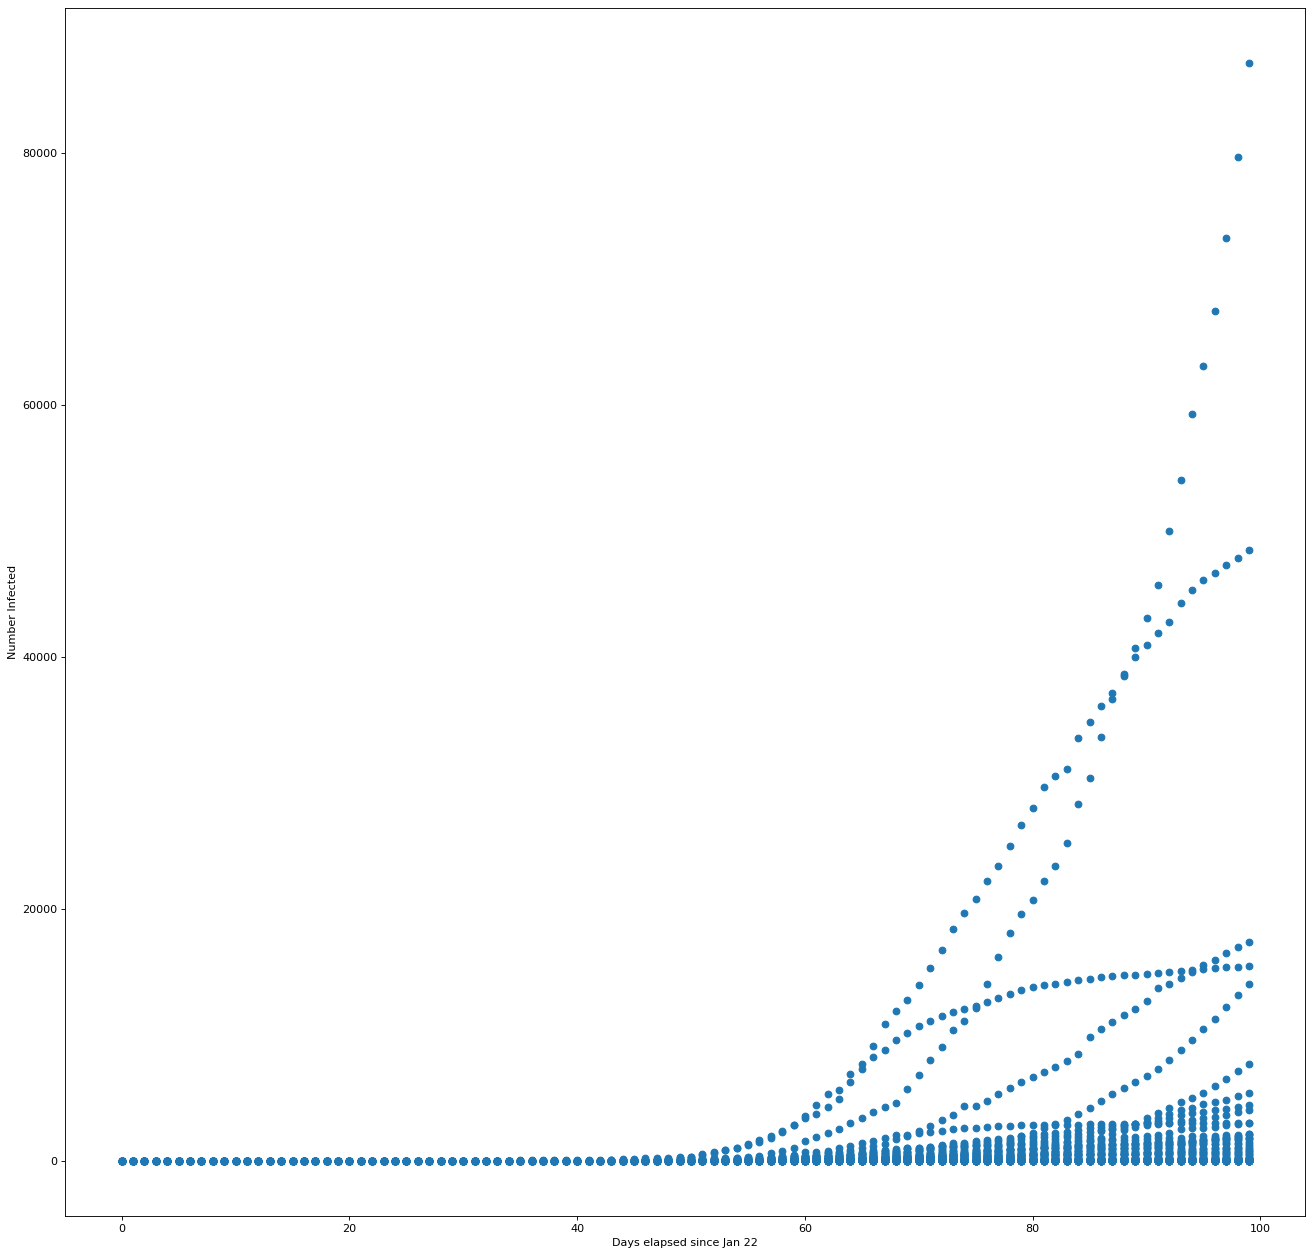

In [ ]:
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.xlabel('Days elapsed since Jan 22')
plt.ylabel('Number Infected')
print(np.shape(X))

Step 6: Lets spilt the data to training and test (70% train, 30% test)

In [ ]:
#Goal1: Fit regression model for (days vs infections)
from sklearn.model_selection import train_test_split
#Split data to train and test
X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Step 7: Let's fit Polynomial features of degree 3 to the features. This results in dimensions going from 3 to 20!

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3)
#Transform both the train and test data
X_train = poly.fit_transform(X_train_1)
X_test = poly.fit_transform(X_test_1)
print("New shape of test data=",np.shape(X_test))

clf = LinearRegression()
#Fit the model on train data only
clf.fit(X_train, y_train)
print("Linear Regression Coefficients are=",clf.coef_)
print("constant coefficient=",clf.intercept_)

New shape of test data= (1500, 20)
Linear Regression Coefficients are= [[ 0.00000000e+00  1.49472285e+00 -1.77011169e+01 -7.44377620e+00
  -2.62371164e+00 -1.66783679e-01 -1.32523607e+00  1.32613637e-01
   1.60019698e-01 -5.80740444e-01  4.74622499e-02  8.72080430e-03
   4.50831003e-02 -2.04127549e-03  1.26028661e-02  2.75122310e-03
   2.97102909e-04 -9.33173379e-04 -3.45730697e-03  9.73845530e-03]]
constant coefficient= [515.00766133]


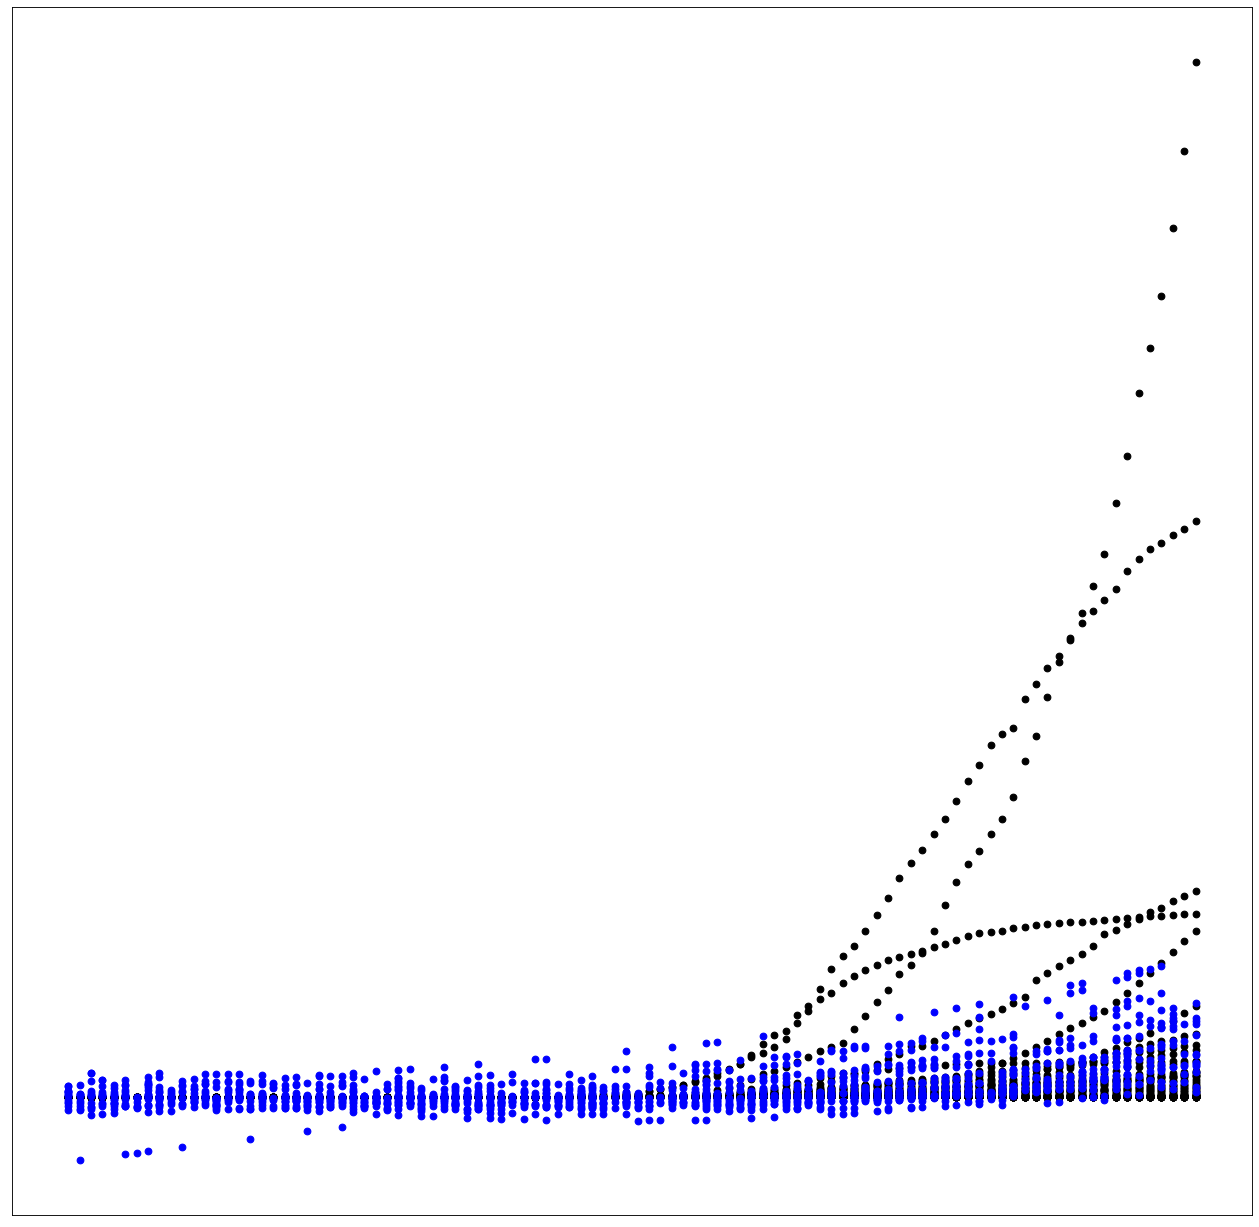

In [ ]:
# Predict regression outcome on test data
y_pred = clf.predict(X_test)
#next plot predictions
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2], Y[:,0],  color='black')
plt.scatter(X_test_1[:,2], y_pred, color='blue', linewidth=1)
plt.xticks(())
plt.yticks(())

plt.show()

In the image above, black points are training and blue ones are test!

In [ ]:
from sklearn.metrics import mean_squared_error as mse
print(mse(y_test, y_pred))

20560548.002745174


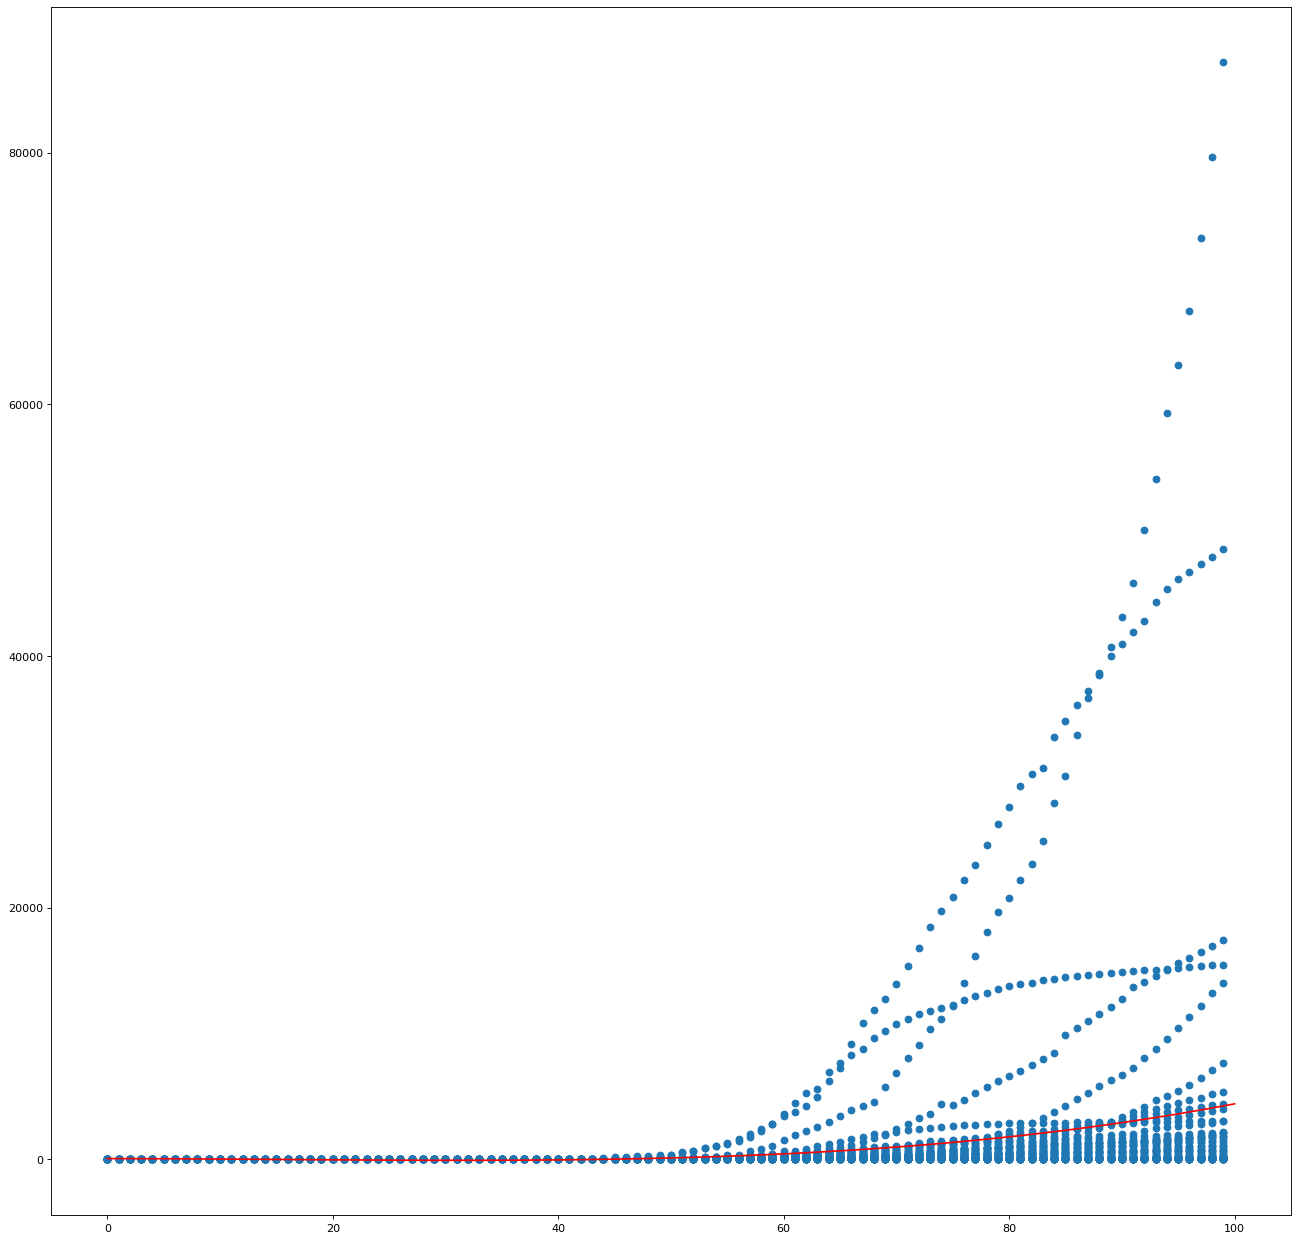

In [ ]:
#1D polynomial regression
model = np.poly1d(np.polyfit(np.transpose(X_train_1[:,2]), np.transpose(y_train[:,0]), 3))

model_x = np.linspace(0, 100, 100)
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(X[:,2],Y[:])
plt.plot(model_x, model(model_x),'r')
plt.show()

In [ ]:
#Assignment: Report the mean squared error for prediction using differnt degrees of Polynomial Regression
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

degree = range(1, 21)

g = {}
for i in degree:
  poly = PolynomialFeatures(degree=i, include_bias=False)
  #Transform both the train and test data
  X_train = poly.fit_transform(X_train_1)
  X_test = poly.fit_transform(X_test_1)
  clf = LinearRegression()
  clf.fit(X_train, y_train)
  print("Number of Linear Regression Coefficients are : ",clf.coef_.shape)
  print("constant coefficient=",clf.intercept_)

  # Predict regression outcome on test data
  y_pred = clf.predict(X_test)
  g[i] = mse(y_test, y_pred)
  print(f"MSE for polynomial of degree {i} : {mse(y_test, y_pred)} \n")

Number of Linear Regression Coefficients are :  (1, 3)
constant coefficient= [-960.19930415]
MSE for polynomial of degree 1 : 23711527.61192565 

Number of Linear Regression Coefficients are :  (1, 9)
constant coefficient= [233.2548977]
MSE for polynomial of degree 2 : 22409841.31414668 

Number of Linear Regression Coefficients are :  (1, 19)
constant coefficient= [515.00766132]
MSE for polynomial of degree 3 : 20560548.00274569 

Number of Linear Regression Coefficients are :  (1, 34)
constant coefficient= [-1092.08225601]
MSE for polynomial of degree 4 : 18011629.557479747 

Number of Linear Regression Coefficients are :  (1, 55)
constant coefficient= [998.01244917]
MSE for polynomial of degree 5 : 14193417.506253826 

Number of Linear Regression Coefficients are :  (1, 83)
constant coefficient= [-323.35994772]
MSE for polynomial of degree 6 : 9116091.73633556 

Number of Linear Regression Coefficients are :  (1, 119)
constant coefficient= [-520.48671476]
MSE for polynomial of degre

In [ ]:
#1. Report the best model for this data
#for i in degree:
  #print("For polynomial degree {:.0f}, the MSE is {:.2f}".format(i, g[i]))

print(f'The best model is polynomial with degree 18 and MSE 12336.65')

The best model is polynomial with degree 18 and MSE 12336.65


In [ ]:
#2. Repeat for complete data (Change step 3) and report the best model
rows=266
cols=225
data_new=data.iloc[0:rows,4:cols]
print(data_new.shape)

#Finding the date indices
import matplotlib.pyplot as plt
data_row=data_new.sum(axis=0)
days=range(0,data_row.shape[0])
days_mat=matlib.repmat(np.array(days),data_new.shape[0],1)

#Lets create data X-{X1,X2,X3}, where X1=lat, X2=long, X3=date, Y=#affected
X=np.zeros((days_mat.shape[0]*days_mat.shape[1],3))
Y=np.zeros((days_mat.shape[0]*days_mat.shape[1],1))
lat_long=np.array(data.iloc[:,2:4])
data_new=np.array(data_new)
for r in range(days_mat.shape[0]): #all locations
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],0]=lat_long[r,0]*np.ones((days_mat.shape[1],)) #setting Latitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],1]=lat_long[r,1]*np.ones((days_mat.shape[1],)) #setting Longitude
  X[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1],2]=np.reshape(days,(days_mat.shape[1],)) #setting the date
  Y[r*days_mat.shape[1]:r*days_mat.shape[1]+days_mat.shape[1]]=np.reshape(data_new[r,:],((days_mat.shape[1],1)))

print(np.shape(X))

X_train_1, X_test_1, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

degree = range(1, 21)

g = {}
for i in degree:
  poly = PolynomialFeatures(degree=i, include_bias=False)
  #Transform both the train and test data
  X_train = poly.fit_transform(X_train_1)
  X_test = poly.fit_transform(X_test_1)
  clf = LinearRegression()
  clf.fit(X_train, y_train)
  print("Number of Linear Regression Coefficients are : ",clf.coef_.shape)
  print("constant coefficient=",clf.intercept_)

  # Predict regression outcome on test data
  y_pred = clf.predict(X_test)
  g[i] = mse(y_test, y_pred)
  print(f"MSE for polynomial of degree {i} : {mse(y_test, y_pred)} \n")

(266, 221)
(58786, 3)
Number of Linear Regression Coefficients are :  (1, 3)
constant coefficient= [-16373.36041918]
MSE for polynomial of degree 1 : 34692587980.73095 

Number of Linear Regression Coefficients are :  (1, 9)
constant coefficient= [-16653.71760691]
MSE for polynomial of degree 2 : 34331186667.30354 

Number of Linear Regression Coefficients are :  (1, 19)
constant coefficient= [2756.56832455]
MSE for polynomial of degree 3 : 34001833764.349392 

Number of Linear Regression Coefficients are :  (1, 34)
constant coefficient= [1654.77859391]
MSE for polynomial of degree 4 : 33433232648.548744 

Number of Linear Regression Coefficients are :  (1, 55)
constant coefficient= [-11547.2047657]
MSE for polynomial of degree 5 : 31991022658.60035 

Number of Linear Regression Coefficients are :  (1, 83)
constant coefficient= [35911.95181877]
MSE for polynomial of degree 6 : 29944205563.026985 

Number of Linear Regression Coefficients are :  (1, 119)
constant coefficient= [17064.229

In [ ]:
print(f'The best model is polynomial with degree 20 and MSE {sorted(g.values())[0]}')

The best model is polynomial with degree 20 and MSE 3310078917.998774
